## Imports

In [15]:
# %pip install numpy pandas matplotlib scikit-learn seaborn cufflinks xgboost plotly lightgb imbalanced-learn geopandas

In [16]:

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import cufflinks as cf
import numpy as np
import geopandas as gpd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

import plotly.graph_objects as px


# Int cufflinks
# making all charts public and setting a global theme
cf.set_config_file(theme='ggplot',offline=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set matplotlib in Darkmode
# plt.style.use('light_background')

# Set Pandas to display all columsn
pd.set_option("display.max.columns", None)
sns.set_palette("husl")  # Set the color palette


# Dataset Overview

### 01. Load the dataset

In [17]:
dataset = pd.read_csv('data_preprocessing/yield_df.csv', encoding='utf-8', index_col=[0])
dataset = dataset.rename(columns={'hg/ha_yield': 'Crop Yield (hg/ha)', 'Item': 'Crop', 'average_rain_fall_mm_per_year': 'Rainfall (mm/year)', 'pesticides_tonnes': 'Pesticides (tonnes)', 'avg_temp': 'Temperature (Celsius)'})

# Data Preprocessing

### 02. Handle Categorical Variables

In [18]:
# Handle categorical variables
# OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# fit and transform the categorical data in Area and Item
encoded_data = encoder.fit_transform(dataset[["Crop", 'Area']])

# convert the encoded data back into a Pandas DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(["Crop", 'Area']))
df = pd.concat([dataset, encoded_df], axis=1)

### 03. Remove Unnecesary Features

In [19]:
# # # Turn yield into logaritmic
# df['Log Crop Yield (hg/ha)'] = np.log(df['Crop Yield (hg/ha)'])
# df['Log Pesticides (tonnes)'] = np.log(df['Pesticides (tonnes)'])

In [20]:
# Create features and labels (and remove categorical variables)
# features = df.drop(['Crop Yield (hg/ha)','Log Crop Yield (hg/ha)',"Crop",'Area', 'Rainfall (mm/year)'], axis=1)
# labels = df['Log Crop Yield (hg/ha)']
features = df.drop(['Crop Yield (hg/ha)',"Crop",'Area', 'Rainfall (mm/year)'], axis=1)
labels = df['Crop Yield (hg/ha)']

### 04. Split Dataset

In [21]:
# Create training (75%) and test (25%) sets
features_train, features_test , labels_train , labels_test = train_test_split(features, labels, test_size =0.2, random_state=42)
# features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)

print(f'Train: {len(features_train)} features, {len(labels_train)} labels\
      \nTest: {len(features_test)} features, {len(labels_test)} labels')
    # \nVal: {len(features_val)} features, {len(labels_val)} labels\')

Train: 22593 features, 22593 labels      
Test: 5649 features, 5649 labels


# Functions

#### Checking Parameters

In [22]:
def parameter_check_class(pred, labels_test, features_test):
    """Determines R2, MAE, RMSE and Adjusted R2 by CLASS"""
    ft_copy = features_test.copy()
    lt_copy = labels_test.copy()
    # Calculate R^2 and MAE for each class
    r2_scores = {}
    mae_scores = {}
    mae_per_scores = {}
    
    # Reconvert Items feature into a categorical variable
    item_cols = [col for col in ft_copy.columns if col.startswith('Crop_')]
    ft_copy['Crop'] = ft_copy[item_cols].idxmax(axis=1).str.replace('Crop_', '')
    # Drop the one-hot encoded columns
    ft_copy.drop(item_cols, axis=1, inplace=True)
    
    # Reset index so they match
    ft_copy = ft_copy.reset_index(drop=True)
    lt_copy = lt_copy.reset_index(drop=True)
    
    print('\n')
    # Group features by crop type
    for crop, group in ft_copy.groupby(['Crop']):
        idx = group.index.tolist()
        y_true = lt_copy.loc[idx].to_numpy()
        r2 = r2_score(y_true, pred[idx])
        mae = mean_absolute_error(y_true, pred[idx])

        # Calculate the percentage mae
        target_range = max(y_true) - min(y_true)
        percentage_mae = (mae / target_range) * 100

        mae_per_scores[crop] = percentage_mae
        r2_scores[crop] = r2
        mae_scores[crop] = mae

        # print the results
        print(f"{crop}: R^2={r2:.2f}, MAE={mae:.2f}, MAE%={percentage_mae:.2f}%")

    return { 'r2': r2_scores, 'mae':mae_scores, 'mae%': mae_per_scores}

In [23]:
def parameter_check(pred, labels_test):
    """Determines r2, mae, rmse and adjusted r2"""

    # Calculate R-squared
    r2 = r2_score(labels_test , pred)
    print(f"R^2: {r2:.3f}")

    # Calculate MAE
    mae = mean_absolute_error(labels_test, pred)
    print(f"MAE: {mae:.3f}")

    # calculate the percentage mae
    target_range = max(labels_test) - min(labels_test)
    percentage_mae = (mae / target_range) * 100
    print(f"MAE(%): {percentage_mae:.2f}%")

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(labels_test, pred))
    print(f"RMSE {rmse:.3f}")

    # Calculate Adjusted R-squared
    n = len(labels_test)
    p = len(pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f"Adjusted R^2 {adj_r2:.3f}")

    return { 'r2': r2, 'mae':mae, 'rmse':rmse, 'adj_r2':adj_r2, 'mae%': percentage_mae}

In [24]:
def plot_learning_curves(best_model, features_train, labels_train, cv, title):
    """Plot the learning curve of a model"""
    
    train_sizes, train_scores, val_scores = learning_curve(best_model, features_train, labels_train, 
                cv=cv, n_jobs=-1, shuffle=True, random_state=42)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="hotpink")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                    val_scores_mean + val_scores_std, alpha=0.1, color="blue")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="hotpink",
            label="Train")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="blue",
            label="Val")
    plt.title(f'Model {title}')
    plt.legend(loc="best")
    plt.show()

### 05. Paramter Grid

### Hyperparameters

In [42]:
# Parameter grids to search over using gridsearch (for each algorithm)
params = {
'svm' : {
    'scaler': [ MinMaxScaler(), StandardScaler(), 'passthrough' ],
    # 'rgs__degree':[0.01, 0.1, 1, 10],
    # 'rgs__gamma' : [1,3,5],
    # 'rgs__kernel' :['rbf', 'linear', 'poly' ,'sigmoid'],
    # 'rgs__C' : [10, 100],
    # 'rgs__coef0': [0.01, 10, 0.5],
    # 'rgs__epsilon': [0.1, 0.5, 1],
},
'rf': {
    'scaler': [ MinMaxScaler(), StandardScaler(), 'passthrough' ],
    'rgs__n_estimators':[5, 10, 50],
    # 'rgs__max_depth': [5, 20],
    # 'rgs__min_samples_split': [2,3,4],
    # 'rgs__min_samples_leaf': [3,5]
},
'ada':{
    'scaler': [ MinMaxScaler(), StandardScaler(), 'passthrough' ],
    'rgs__n_estimators':[10,100],
    # 'rgs__learning_rate': [0.01, 0.1, 1.0]
},
'elastic':{
    'scaler': [ MinMaxScaler(), StandardScaler(), 'passthrough' ],
    'rgs__alpha':[0.01, 1.0, 10.0,],
    # 'rgs__l1_ratio':[0.1,0.5, 0.7],
},
'xgb':{
    'scaler': [ MinMaxScaler(), StandardScaler(), 'passthrough' ],
    'rgs__n_estimators': [100,250, 500],
    # 'rgs__max_depth': [3, 6, 12],
    # 'rgs__learning_rate': [0.05, 0.1, 0.20],
    # 'rgs__min_child_weight': [1, 10],
    # 'rgs__gamma' : [0,0.1,0.5],
    # 'rgs__reg_alpha' : [0, 0.1, 0.5],
    # 'rgs__reg_lambda': [0, 0.1, 0.5],
    
},
'sgdr' : {
    'scaler': [ MinMaxScaler(), StandardScaler(), 'passthrough' ],
    'rgs__alpha':[1e-1, 10.0, 100.0],
    # 'rgs__l1_ratio':[0.1, 0.5, 1],

},
'lgbmr' : {
    'scaler': [ MinMaxScaler(), StandardScaler(), 'passthrough' ],
    'rgs__n_estimators': [50, 100],
    # 'rgs__max_depth': [-1, 0, 1],
    # 'rgs__learning_rate': [0.05, 0.1, 0.20],
    # 'rgs__min_child_weight': [0.01, 0.1]
    
}
}

In [43]:
params_df_out = pd.DataFrame.from_dict(params)
params_df_out

,svm,rf,ada,elastic,xgb,sgdr,lgbmr
scaler,"[MinMaxScaler(), StandardScaler(), passthrough]","[MinMaxScaler(), StandardScaler(), passthrough]","[MinMaxScaler(), StandardScaler(), passthrough]","[MinMaxScaler(), StandardScaler(), passthrough]","[MinMaxScaler(), StandardScaler(), passthrough]","[MinMaxScaler(), StandardScaler(), passthrough]","[MinMaxScaler(), StandardScaler(), passthrough]"
rgs__n_estimators,NaN,"[5, 10, 50]","[10, 100]",NaN,"[100, 250, 500]",NaN,"[50, 100]"
rgs__alpha,NaN,NaN,NaN,"[0.01, 1.0, 10.0]",NaN,"[0.1, 10.0, 100.0]",NaN


### Pipeline

In [27]:
def build_pipeline(params, regressor, features_train, labels_train, features_test, labels_test):
    # Setting up a pipeline
    pipe = Pipeline([
        ('scaler', None),
        ('rgs', regressor)
    ])

    # Cross validation
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

    # Set up the grid search
    gs = GridSearchCV(estimator=pipe,param_grid=params,n_jobs=-1, verbose=10, cv=cv,scoring='r2')

    # Fit gs to training data
    gs_results = gs.fit(features_train, labels_train)

    # Plot learning curves
    plot_learning_curves(gs.best_estimator_, features_train, labels_train, cv, str(regressor))

    # Find best fit
    print(f'Best score: {gs_results.best_score_}')
    print(f'Best parameters: \n{gs_results.best_params_}')

    # Get score
    print(f'\nScore: {gs.score(features_test, labels_test)}')

    # Predict results
    labels_preds = gs.predict(features_test)
    best_par = parameter_check(labels_preds, labels_test)
    best_par_class = parameter_check_class(labels_preds, labels_test, features_test)
    
    return best_par, best_par_class, gs_results 

# Model Comparison

### 06. Run Models

Random Forest

Fitting 15 folds for each of 9 candidates, totalling 135 fits


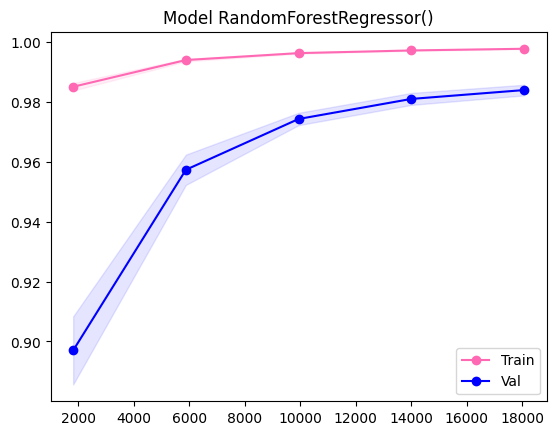

Best score: 0.9842150112763238
Best parameters: 
{'rgs__n_estimators': 50, 'scaler': StandardScaler()}

Score: 0.9869866219688435
R^2: 0.987
MAE: 3660.704
MAE(%): 0.76%
RMSE 9715.697
Adjusted R^2 74.500


Cassava: R^2=0.98, MAE=5223.98, MAE%=1.40%
Maize: R^2=0.97, MAE=2291.53, MAE%=1.83%
Plantains and others: R^2=0.92, MAE=8784.33, MAE%=2.21%
Potatoes: R^2=0.96, MAE=8869.78, MAE%=1.88%
Rice, paddy: R^2=0.96, MAE=2000.53, MAE%=2.01%
Sorghum: R^2=0.93, MAE=1792.31, MAE%=2.38%
Soybeans: R^2=0.94, MAE=969.23, MAE%=2.34%
Sweet potatoes: R^2=0.97, MAE=5210.53, MAE%=1.54%
Wheat: R^2=0.96, MAE=1724.45, MAE%=1.79%
Yams: R^2=0.98, MAE=3393.64, MAE%=1.59%


In [28]:
best_par_rf, best_par_rf_class, score_rf = build_pipeline(params['rf'], RandomForestRegressor(), features_train, labels_train, features_test, labels_test)

SVM

Fitting 15 folds for each of 3 candidates, totalling 45 fits


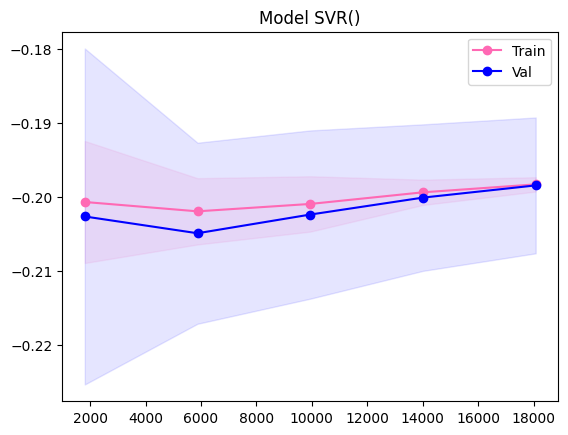

Best score: -0.19843188085399535
Best parameters: 
{'scaler': MinMaxScaler()}

Score: -0.1953181600715015
R^2: -0.195
MAE: 56983.755
MAE(%): 11.78%
RMSE 93115.229
Adjusted R^2 6752.157


Cassava: R^2=-1.45, MAE=106867.49, MAE%=28.62%
Maize: R^2=-0.01, MAE=21743.61, MAE%=17.33%
Plantains and others: R^2=-0.84, MAE=69548.58, MAE%=17.51%
Potatoes: R^2=-2.99, MAE=162430.62, MAE%=34.40%
Rice, paddy: R^2=-0.02, MAE=15232.00, MAE%=15.33%
Sorghum: R^2=-1.39, MAE=21604.62, MAE%=28.64%
Soybeans: R^2=-8.23, MAE=21494.59, MAE%=51.91%
Sweet potatoes: R^2=-1.33, MAE=82027.93, MAE%=24.23%
Wheat: R^2=-0.24, MAE=17567.72, MAE%=18.26%
Yams: R^2=-1.88, MAE=77142.42, MAE%=36.13%


In [44]:
best_par_svm, best_par_svm_class, score_svm = build_pipeline(params['svm'], SVR(), features_train, labels_train, features_test, labels_test)

AdaBoost

Fitting 15 folds for each of 6 candidates, totalling 90 fits


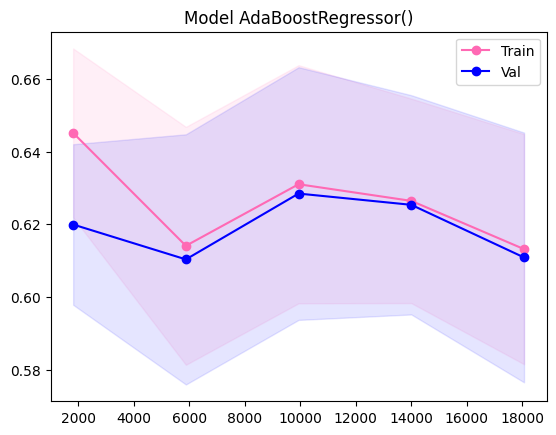

Best score: 0.6330112601270119
Best parameters: 
{'rgs__n_estimators': 10, 'scaler': 'passthrough'}

Score: 0.6419816523113145
R^2: 0.642
MAE: 40639.972
MAE(%): 8.40%
RMSE 50960.256
Adjusted R^2 2023.088


Cassava: R^2=0.69, MAE=40138.14, MAE%=10.75%
Maize: R^2=-0.67, MAE=31373.62, MAE%=25.01%
Plantains and others: R^2=-0.31, MAE=52844.22, MAE%=13.31%
Potatoes: R^2=0.39, MAE=57967.74, MAE%=12.28%
Rice, paddy: R^2=-0.59, MAE=22345.85, MAE%=22.49%
Sorghum: R^2=-5.72, MAE=37438.57, MAE%=49.64%
Soybeans: R^2=-28.96, MAE=40223.99, MAE%=97.14%
Sweet potatoes: R^2=-0.04, MAE=57312.93, MAE%=16.93%
Wheat: R^2=-2.27, MAE=30656.76, MAE%=31.86%
Yams: R^2=-1.10, MAE=60819.66, MAE%=28.48%


In [30]:
best_par_ada, best_par_ada_class, score_ada = build_pipeline(params['ada'], AdaBoostRegressor(), features_train, labels_train, features_test, labels_test)

Elastic Net

Fitting 15 folds for each of 9 candidates, totalling 135 fits


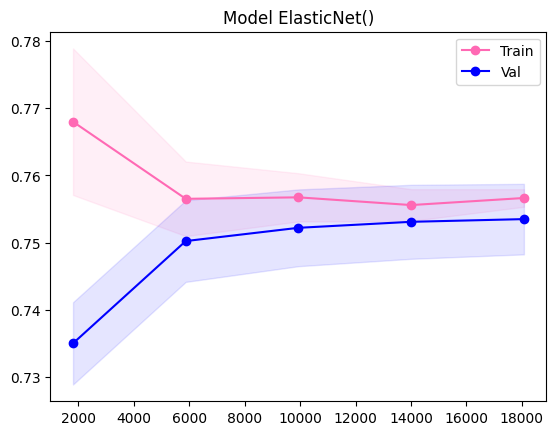

Best score: 0.7534971035948758
Best parameters: 
{'rgs__alpha': 0.01, 'scaler': StandardScaler()}

Score: 0.7552352759765033
R^2: 0.755
MAE: 29498.734
MAE(%): 6.10%
RMSE 42136.006
Adjusted R^2 1383.431


Cassava: R^2=0.29, MAE=60626.70, MAE%=16.24%
Maize: R^2=-0.03, MAE=20625.98, MAE%=16.44%
Plantains and others: R^2=0.34, MAE=40340.70, MAE%=10.16%
Potatoes: R^2=0.56, MAE=49413.80, MAE%=10.47%
Rice, paddy: R^2=-0.08, MAE=15506.72, MAE%=15.61%
Sorghum: R^2=-1.09, MAE=17268.22, MAE%=22.90%
Soybeans: R^2=-11.64, MAE=20384.09, MAE%=49.23%
Sweet potatoes: R^2=0.42, MAE=38919.12, MAE%=11.50%
Wheat: R^2=-1.31, MAE=20572.88, MAE%=21.38%
Yams: R^2=0.62, MAE=28941.00, MAE%=13.55%


In [31]:
best_par_elastic, best_par_elastic_class, score_elastic = build_pipeline(params['elastic'], ElasticNet(), features_train, labels_train, features_test, labels_test)

X-Gradient Boost

Fitting 15 folds for each of 9 candidates, totalling 135 fits


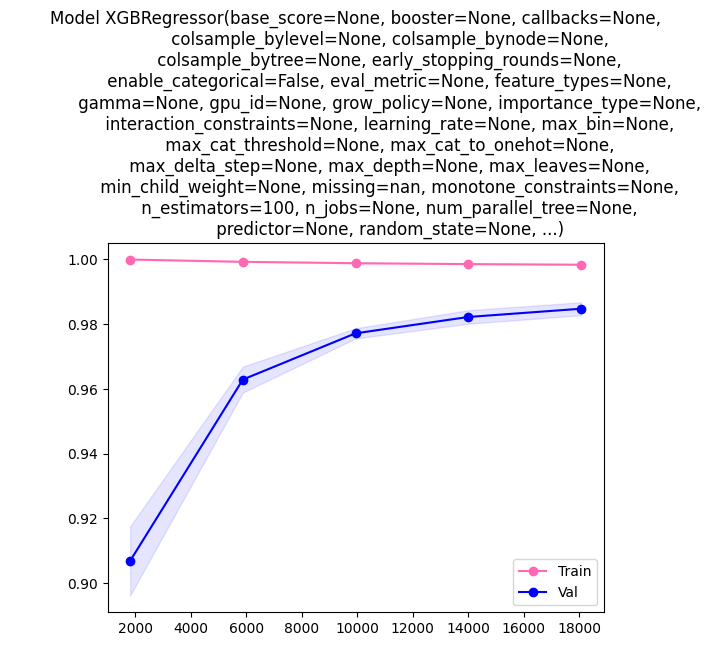

Best score: 0.9844937249086463
Best parameters: 
{'rgs__n_estimators': 500, 'scaler': MinMaxScaler()}

Score: 0.9860730215998244
R^2: 0.986
MAE: 4737.667
MAE(%): 0.98%
RMSE 10050.957
Adjusted R^2 79.660


Cassava: R^2=0.98, MAE=6396.96, MAE%=1.71%
Maize: R^2=0.96, MAE=3136.46, MAE%=2.50%
Plantains and others: R^2=0.91, MAE=10929.70, MAE%=2.75%
Potatoes: R^2=0.96, MAE=10311.71, MAE%=2.18%
Rice, paddy: R^2=0.95, MAE=2938.25, MAE%=2.96%
Sorghum: R^2=0.91, MAE=2706.50, MAE%=3.59%
Soybeans: R^2=0.88, MAE=1861.61, MAE%=4.50%
Sweet potatoes: R^2=0.96, MAE=6537.89, MAE%=1.93%
Wheat: R^2=0.95, MAE=2584.70, MAE%=2.69%
Yams: R^2=0.98, MAE=4740.12, MAE%=2.22%


In [32]:
best_par_xgb, best_par_xgb_class, score_xgb = build_pipeline(params['xgb'], xgb.XGBRegressor(), features_train, labels_train, features_test, labels_test)

SGDR Regressor

Fitting 15 folds for each of 9 candidates, totalling 135 fits


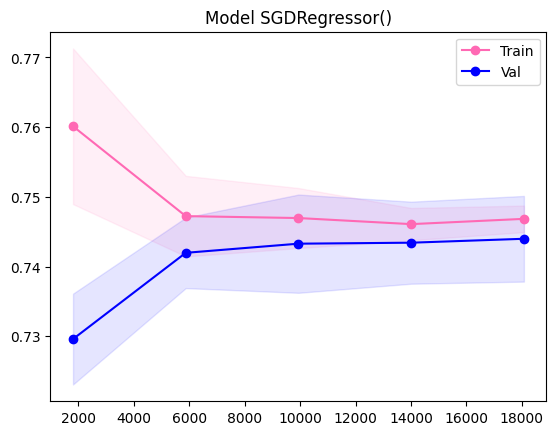

Best score: 0.7429022279573178
Best parameters: 
{'rgs__alpha': 0.1, 'scaler': StandardScaler()}

Score: 0.7495247057805736
R^2: 0.750
MAE: 28734.014
MAE(%): 5.94%
RMSE 42624.707
Adjusted R^2 1415.684


Cassava: R^2=0.22, MAE=59075.06, MAE%=15.82%
Maize: R^2=0.04, MAE=19362.39, MAE%=15.43%
Plantains and others: R^2=0.36, MAE=44042.39, MAE%=11.09%
Potatoes: R^2=0.53, MAE=49710.78, MAE%=10.53%
Rice, paddy: R^2=0.08, MAE=14402.89, MAE%=14.50%
Sorghum: R^2=-0.75, MAE=16069.20, MAE%=21.31%
Soybeans: R^2=-9.96, MAE=18604.54, MAE%=44.93%
Sweet potatoes: R^2=0.37, MAE=40484.53, MAE%=11.96%
Wheat: R^2=-0.90, MAE=18503.58, MAE%=19.23%
Yams: R^2=0.62, MAE=28669.87, MAE%=13.43%


In [33]:
best_par_sgdr, best_par_sgdr_class, score_sgdr = build_pipeline(params['sgdr'], SGDRegressor(), features_train, labels_train, features_test, labels_test)

LGBM Regressor

Fitting 15 folds for each of 6 candidates, totalling 90 fits


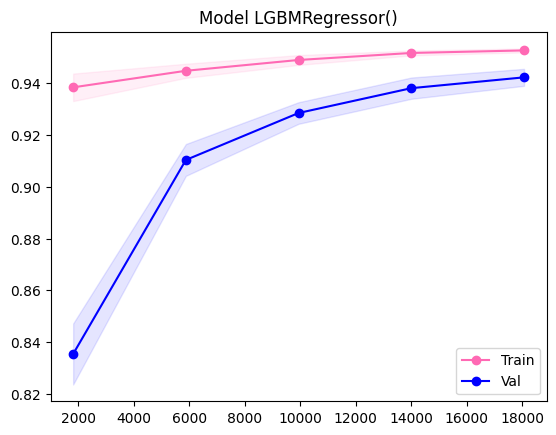

Best score: 0.9421561037606786
Best parameters: 
{'rgs__n_estimators': 100, 'scaler': StandardScaler()}

Score: 0.945130918117704
R^2: 0.945
MAE: 11978.472
MAE(%): 2.48%
RMSE 19949.996
Adjusted R^2 310.901


Cassava: R^2=0.92, MAE=17181.56, MAE%=4.60%
Maize: R^2=0.73, MAE=9449.19, MAE%=7.53%
Plantains and others: R^2=0.69, MAE=25849.32, MAE%=6.51%
Potatoes: R^2=0.87, MAE=24009.92, MAE%=5.09%
Rice, paddy: R^2=0.71, MAE=7550.55, MAE%=7.60%
Sorghum: R^2=0.73, MAE=6156.96, MAE%=8.16%
Soybeans: R^2=0.23, MAE=4923.69, MAE%=11.89%
Sweet potatoes: R^2=0.86, MAE=16522.38, MAE%=4.88%
Wheat: R^2=0.74, MAE=6863.68, MAE%=7.13%
Yams: R^2=0.87, MAE=13840.96, MAE%=6.48%


In [34]:
best_par_lgbmr, best_par_sgdr_class, score_lgbmr = build_pipeline(params['lgbmr'], LGBMRegressor(), features_train, labels_train, features_test, labels_test)

### 07. Comparison

#### Parameter Comparison

In [45]:
# Plot out different parameters
compare = [best_par_svm, best_par_rf, best_par_ada, best_par_elastic, best_par_xgb, best_par_sgdr, best_par_lgbmr ]
headers_comparison = ['SVM','RandomForest','AdaBoost', 'ElasticNet', 'XGradBoost', 'SGDR', 'LGBMR']

In [46]:
compare_df = pd.DataFrame(compare)
compare_df["results"]=headers_comparison
compare_df = compare_df.set_index('results', drop=True).rename_axis(None)
compare_df

,r2,mae,rmse,adj_r2,mae%
SVM,-0.195318,56983.754704,93115.228797,6752.156968,11.779466
RandomForest,0.986987,3660.704351,9715.697374,74.499559,0.756727
AdaBoost,0.641982,40639.972166,50960.255628,2023.087628,8.400941
ElasticNet,0.755235,29498.733589,42136.006195,1383.431161,6.097866
XGradBoost,0.986073,4737.666937,10050.956813,79.659574,0.979353
SGDR,0.749525,28734.013526,42624.706698,1415.684462,5.939786
LGBMR,0.945131,11978.472357,19949.995522,310.900574,2.476144


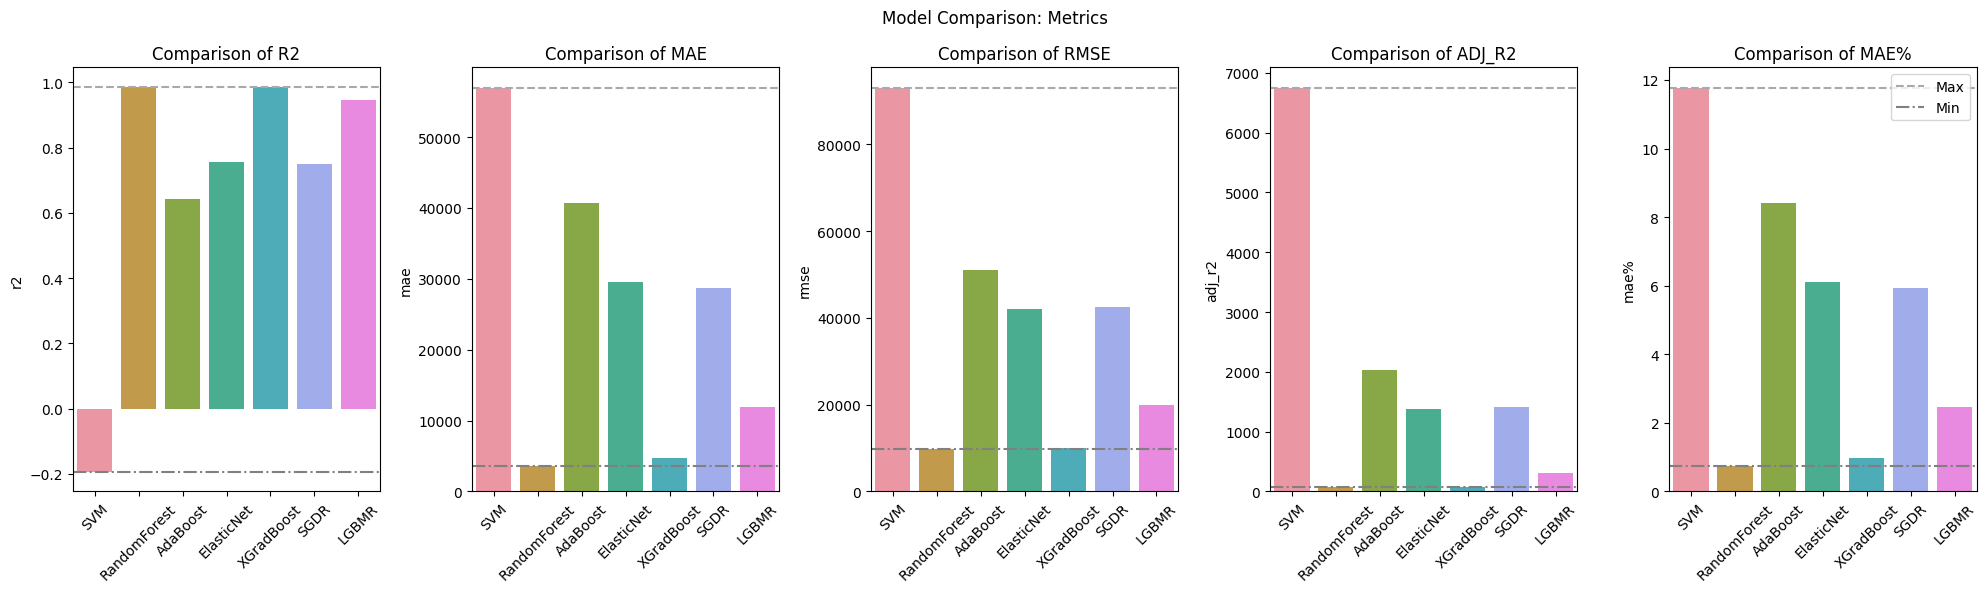

In [47]:
# Set the figure size
plt.figure(figsize=(20, 6))

metrics = compare_df.columns

# Plot multiple bar plots side by side
for i, metric in enumerate(metrics):
    plt.subplot(1, 5, i + 1)
    sns.barplot(data=compare_df, x=compare_df.index, y=metric)
    plt.title(f'Comparison of {metric.upper()}')
    plt.xticks(rotation=45)

    # Place a horizontal line at the position of Best Score
    max_score = compare_df[metric].max()
    min_score = compare_df[metric].min()
    plt.axhline(max_score, color='darkgrey', linestyle='--', label='Max')
    plt.axhline(min_score, color='grey', linestyle='-.', label='Min')

# Add title to the whole figure
plt.suptitle('Model Comparison: Metrics')

# Adjust spacing between subplots
plt.tight_layout(h_pad=5.5)
plt.legend()

# Show the plot
plt.show()

#### Score Comparison

In [48]:
def get_scores(gs_results):
    """Return hs_results in dictionary"""
    return {
        'Best Score' : gs_results.best_score_,
        'Best parameters': gs_results.best_params_,
        'Means' : gs_results.cv_results_['mean_test_score'],
        'Stds' : gs_results.cv_results_['std_test_score'],
        'Params' : gs_results.cv_results_['params']
        }

In [49]:
# Plot out different parameters
score_objects = [score_svm, score_rf, score_ada, score_elastic, score_xgb, score_lgbmr ]
compare2 = [ get_scores(x) for x in score_objects  ]

headers_comparison = ['SVM','RandomForest','AdaBoost', 'ElasticNet', 'XGradBoost', 'LGBMR']
compare_df2 = pd.DataFrame(compare2)
compare_df2["results"]=headers_comparison
compare_df2 = compare_df2.set_index('results', drop=True).rename_axis(None)

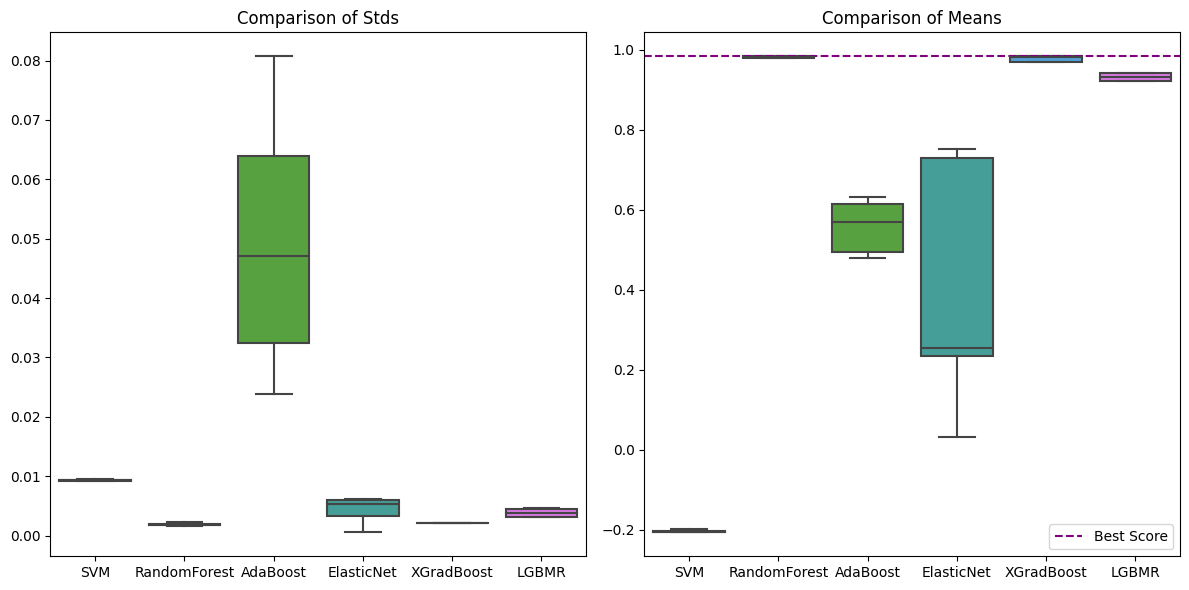

In [50]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Define the subplots
plt.subplot(1, 2, 1)  # First subplot
sns.boxplot(data=compare_df2['Stds'])
plt.title('Comparison of Stds')
# Assign index names to x-ticks
plt.xticks(range(len(compare_df2)), compare_df2.index)

plt.subplot(1, 2, 2)  # Second subplot
sns.boxplot(data=compare_df2['Means'])
plt.title('Comparison of Means')
# Assign index names to x-ticks
plt.xticks(range(len(compare_df2)), compare_df2.index)

# Place a horizontal line at the position of Best Score
best_score = compare_df2['Best Score'].max()
plt.axhline(best_score, color='purple', linestyle='--', label='Best Score')
plt.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()